# Описание проекта: промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. 

## Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:

1. **data_arc_new.csv** — данные об электродах:
   - `key` — номер партии;
   - `Начало нагрева дугой` — время начала нагрева;
   - `Конец нагрева дугой` — время окончания нагрева;
   - `Активная мощность` — значение активной мощности;
   - `Реактивная мощность` — значение реактивной мощности.

2. **data_bulk_new.csv** — данные о подаче сыпучих материалов (объём):
   - `key` — номер партии;
   - `Bulk 1 … Bulk 15` — объём подаваемого материала.

3. **data_bulk_time_new.csv** — данные о подаче сыпучих материалов (время):
   - `key` — номер партии;
   - `Bulk 1 … Bulk 15` — время подачи материала.

4. **data_gas_new.csv** — данные о продувке сплава газом:
   - `key` — номер партии;
   - `Газ 1` — объём подаваемого газа.

5. **data_temp_new.csv** — результаты измерения температуры:
   - `key` — номер партии;
   - `Время замера` — время замера;
   - `Температура` — значение температуры.

6. **data_wire_new.csv** — данные о проволочных материалах (объём):
   - `key` — номер партии;
   - `Wire 1 … Wire 15` — объём подаваемых проволочных материалов.

7. **data_wire_time_new.csv** — данные о проволочных материалах (время):
   - `key` — номер партии;
   - `Wire 1 … Wire 15` — время подачи проволочных материалов.

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки. Данные также находятся в тренажёре, в папке `/datasets/`.

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 131223

## Загрузка данных

Загрузим данные и посмотрим на них.

In [2]:
# Загрузка данных
data_arc = pd.read_csv('/datasets/data_arc_new.csv')
data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
data_gas = pd.read_csv('/datasets/data_gas_new.csv')
data_temp = pd.read_csv('/datasets/data_temp_new.csv')
data_wire = pd.read_csv('/datasets/data_wire_new.csv')
data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

with pd.option_context('display.max_columns', None):
    display("Data Arc:")
    display(data_arc)

    display("\nData Bulk:")
    display(data_bulk)

    display("\nData Bulk Time:")
    display(data_bulk_time)

    display("\nData Gas:")
    display(data_gas)

    display("\nData Temp:")
    display(data_temp)

    display("\nData Wire:")
    display(data_wire)

    display("\nData Wire Time:")
    display(data_wire_time)

'Data Arc:'

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543


'\nData Bulk:'

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


'\nData Bulk Time:'

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-09-06 11:54:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 11:49:45,NaN,2019-09-06 11:45:22,2019-09-06 11:40:06
3125,3238,NaN,NaN,2019-09-06 12:26:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 12:18:35,NaN,2019-09-06 12:31:49,2019-09-06 12:26:52
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:06:00,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:01:44,NaN,2019-09-06 14:58:15,2019-09-06 14:48:06
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:24:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:07:29,2019-09-06 16:01:34


'\nData Gas:'

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


'\nData Temp:'

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


'\nData Wire:'

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'\nData Wire Time:'

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-09-06 11:33:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-09-06 12:18:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-06 14:36:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-06 15:33:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
datasets = {
    'data_arc': data_arc,
    'data_bulk': data_bulk,
    'data_bulk_time': data_bulk_time,
    'data_gas': data_gas,
    'data_temp': data_temp,
    'data_wire': data_wire,
    'data_wire_time': data_wire_time
}

for dataset_name, dataset in datasets.items():
    print(f'Датасет: {dataset_name}')
    print('Пропущенные значения:')
    print(dataset.isna().sum())
    print("\nИнформация о датасете:")
    print(dataset.info())
    print("\nОписание датасета:")
    print(dataset.describe())
    print("\n" + "="*50 + "\n")


Датасет: data_arc
Пропущенные значения:
key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None

Описание датасета:
                key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.662752             0.438986
std      934.571502           0.258885             5.873485

## Первичный анализ данных

**Датасет: data_arc**

*Пропущенные значения:*
- Колонки не содержат пропущенных значений.

*Информация о датасете:*
- Всего 14876 записей.
- Колонки "Начало нагрева дугой" и "Конец нагрева дугой" имеют тип object, требует преобразования в формат даты и времени.
- Для "Активной мощности" и "Реактивной мощности" используется числовой формат.

*Описание датасета:*
- Средние значения активной и реактивной мощности близки к средним значениям в рамках стандартных технологических процессов.
- Минимальное значение реактивной мощности отрицательно, что может потребовать дополнительного анализа.

**Датасет: data_bulk**

*Пропущенные значения:*
- Множество колонок, связанных с добавками, содержат пропущенные значения. На этих этапах добавки не производились.

*Информация о датасете:*
- Всего 3129 записей.
- Большинство добавок имеют различное количество пропущенных значений.
- В некоторых случаях пропущены все значения (например, "Bulk 8").

*Описание датасета:*
- Разные добавки имеют разные средние и стандартные отклонения, что может быть связано с их химическим составом.

**Датасет: data_bulk_time**

*Пропущенные значения:*
- Как и в предыдущем датасете, множество пропущенных значений в колонках, связанных с добавками.

*Информация о датасете:*
- Схож с data_bulk в структурном аспекте.

*Описание датасета:*
- Как и в data_bulk, временные добавки имеют разное среднее и стандартное отклонение.

**Датасет: data_gas**

*Пропущенные значения:*
- Все колонки не содержат пропущенных значений.

*Информация о датасете:*
- Всего 3239 записей.
- Колонка "Газ 1" представляет измерения газа.

*Описание датасета:*
- Среднее значение и стандартное отклонение соответствуют стандартным характеристикам производственных процессов.

**Датасет: data_temp**

*Пропущенные значения:*
- Пропущенные значения в колонке "Температура".

*Информация о датасете:*
- Всего 18092 записи.
- Колонка "Время замера" имеет тип object, требует преобразования в формат даты и времени.

*Описание датасета:*
- Среднее значение температуры соответствует типичным значениям в металлургических процессах.
- Присутствуют пропущенные значения в колонке "Температура", что может потребовать дополнительного внимания.

**Датасет: data_wire**

*Пропущенные значения:*
- Различные колонки, связанные с проволокой, содержат пропущенные значения.

*Информация о датасете:*
- Всего 3081 запись.

*Описание датасета:*
- Разные типы проволоки имеют разные средние значения и стандартные отклонения.

**Датасет: data_wire_time**

*Пропущенные значения:*
- Как и в предыдущем датасете, различные колонки с временем связаны с проволокой и содержат пропущенные значения.

*Информация о датасете:*
- Схож с data_wire в структурном аспекте.

*Описание датасета:*
- Как и в data_wire, временные значения проволоки имеют разное среднее и стандартное отклонение.

**Выводы:**
1. Необходимо провести преобразование типов данных для временных колонок (например, "Начало нагрева дугой", "Конец нагрева дугой", "Время замера").
2. Присутствуют пропущенные значения в нескольких датасетах, что может потребовать дополнительного анализа и принятия решений по их обработке.
3. Различные добавки и проволока имеют разные характеристики, что может быть важным при дальнейшем анализе данных и моделировании.
4. Присутствуют отрицательные значения в "Реактивной мощности" в data_arc, что также требует внимания.
5. Требуется более детальный анализ пропущенных значений в колонке "Температура" в data_temp для принятия решений о их обработке.

## Предобработка данных

Преобразуем временные колонки в тип данных DateTime

In [4]:
# Преобразование типов данных для временных колонок в data_arc
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])

# Преобразование типов данных для временных колонок в data_temp
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])

# Преобразование типов данных для временных колонок в data_bulk_time
for col in data_bulk_time.columns[1:]:
    data_bulk_time[col] = pd.to_datetime(data_bulk_time[col])

# Преобразование типов данных для временных колонок в data_wire_time
for col in data_wire_time.columns[1:]:
    data_wire_time[col] = pd.to_datetime(data_wire_time[col])

# Вывод обновленной информации о типах данных для временных колонок
datasets = {
    'data_arc': data_arc,
    'data_temp': data_temp,
    'data_bulk_time': data_bulk_time,
    'data_wire_time': data_wire_time
}

for dataset_name, dataset in datasets.items():
    print(f'Датасет: {dataset_name}')
    print("\nИнформация о датасете после преобразования типов данных:")
    print(dataset.info())
    print("\n" + "="*50 + "\n")


Датасет: data_arc

Информация о датасете после преобразования типов данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB
None


Датасет: data_temp

Информация о датасете после преобразования типов данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64       

Необходимо изучить графики boxplot для выявления возможных аномалий в датасете data_arc

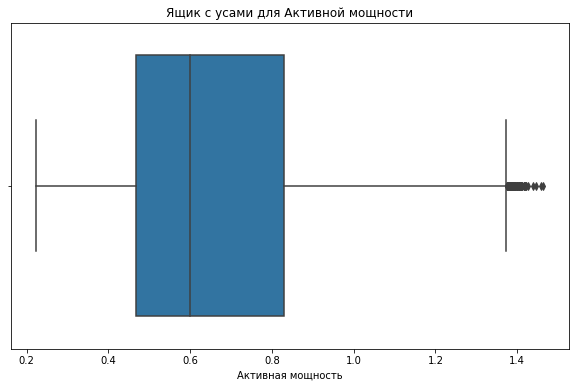

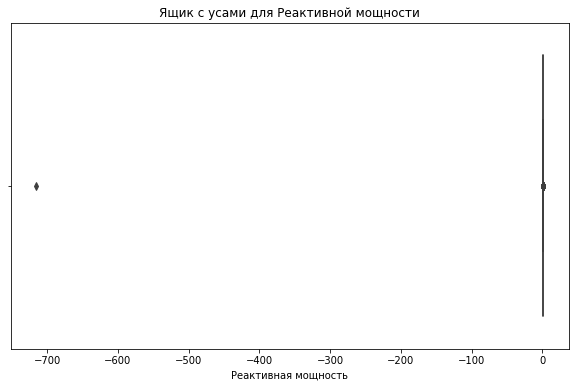

In [5]:
# Построение графика для Активной мощности
plt.figure(figsize=(10, 6))
sns.boxplot(x='Активная мощность', data=data_arc)
plt.title('Ящик с усами для Активной мощности')
plt.xlabel('Активная мощность')
plt.show()

# Построение графика для Реактивной мощности
plt.figure(figsize=(10, 6))
sns.boxplot(x='Реактивная мощность', data=data_arc)
plt.title('Ящик с усами для Реактивной мощности')
plt.xlabel('Реактивная мощность')
plt.show()


На графике реактивной мощности оказалось аномальное значение меньше -700. Значение реактивной мощности может быть отрицательным, но учитывая его величину, сильно отличающуюся от всех остальных. Посмотрим на распределение без этого значения.

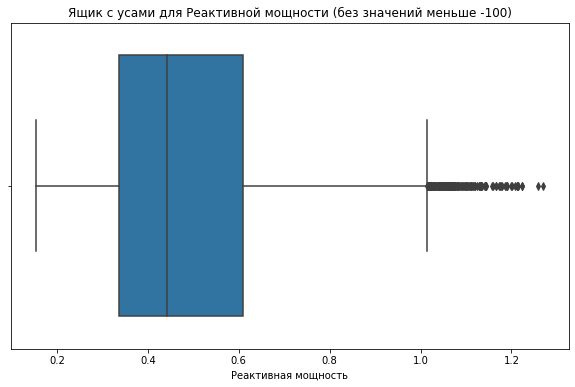

In [6]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Реактивная мощность', data=data_arc[(data_arc['Реактивная мощность'] >= -100)])
plt.title('Ящик с усами для Реактивной мощности (без значений меньше -100)')
plt.xlabel('Реактивная мощность')
plt.show()

Теперь очевидно что это значение - явная аномалия, которую можно заменить, зная отношение среднего значения активной мощности к среднему значению реактивной мощности.

In [7]:
# Фильтрация
filtered_data_arc = data_arc[data_arc['Реактивная мощность'] >= -100]

# Расчет среднего отношения между активной и реактивной мощностью
mean_ratio = (filtered_data_arc['Активная мощность'] / filtered_data_arc['Реактивная мощность']).mean()
print('Среднее отношение между активной и реактивной мощностью: ', mean_ratio)

# Находим строку, которую нужно заменить
row_to_replace = data_arc[data_arc['Реактивная мощность'] < -100].iloc[0]
print('Строка для замены: \n')
display(row_to_replace)

# Заменяем значение Реактивной мощности
new_reactive_power = row_to_replace['Активная мощность'] / mean_ratio
print('Восстновленное значение Реактивной мощности: ', new_reactive_power)
row_to_replace['Реактивная мощность'] = new_reactive_power

# Находим индекс строки, которую нужно заменить
index_to_replace = data_arc[data_arc['Реактивная мощность'] < -100].index[0]

# Заменяем значение Реактивной мощности в оригинальном датафрейме
data_arc.loc[index_to_replace, 'Реактивная мощность'] = new_reactive_power

# Выводим обновленную строку
print("Обновленная строка в data_arc:")
print(data_arc.loc[index_to_replace])

Среднее отношение между активной и реактивной мощностью:  1.3735003434334967
Строка для замены: 



key                                    2116
Начало нагрева дугой    2019-07-28 02:22:08
Конец нагрева дугой     2019-07-28 02:23:57
Активная мощность                  0.705344
Реактивная мощность             -715.479924
Name: 9780, dtype: object

Восстновленное значение Реактивной мощности:  0.5135375490600683
Обновленная строка в data_arc:
key                                    2116
Начало нагрева дугой    2019-07-28 02:22:08
Конец нагрева дугой     2019-07-28 02:23:57
Активная мощность                  0.705344
Реактивная мощность                0.513538
Name: 9780, dtype: object


Нам нужны только те партии, где все данные собраны правильно. Если в одной из колонок название которой содержит 'Wire' или 'Bulk' datetime метка раньше, чем самая ранняя метка в колонке 'Время замера' или позже чем  самая поздняя метка в колонке 'Время замера', то все данные с этим ключом key подлежат удалению, нас интересуют только те данные, где первая и последняя операция - замер температуры.

In [8]:
# Объединение данных
merged_data = pd.merge(data_wire_time, data_bulk_time, on='key', how='outer')
merged_data = pd.merge(merged_data, data_temp, on='key', how='outer')
merged_data = pd.merge(merged_data, data_arc[['key', 'Начало нагрева дугой', 'Конец нагрева дугой']], on='key', how='left')

# Преобразование столбцов Wire и Bulk в список всех соответствующих столбцов
wire_columns = [f'Wire {i}' for i in range(1, 10)]
bulk_columns = [f'Bulk {i}' for i in range(1, 16)]
all_columns = wire_columns + bulk_columns

# Создание нового столбца с минимальным значением datetime
merged_data['min_datetime'] = merged_data[['Начало нагрева дугой', 'Конец нагрева дугой'] + all_columns].min(axis=1)

# Создание нового столбца с максимальным значением datetime
merged_data['max_datetime'] = merged_data[['Начало нагрева дугой', 'Конец нагрева дугой'] + all_columns].max(axis=1)

# Создание нового столбца с минимальным значением Время замера для каждой партии key
merged_data['min_measurement_time'] = merged_data.groupby('key')['Время замера'].transform('min')

# Создание нового столбца с максимальным значением Время замера для каждой партии key
merged_data['max_measurement_time'] = merged_data.groupby('key')['Время замера'].transform('max')

# Функция для проверки условий
def filter_conditions(group):
    group = group.sort_values('Время замера', ascending=False)  # Сортировка по убыванию времени замера
    return (
        (group['min_datetime'].min() < group['min_measurement_time'].min() or
         group['max_datetime'].max() > group['max_measurement_time'].max()) or
        pd.isna(group['Температура'].iloc[0]) or
        pd.isna(group['Температура'].iloc[-1])
    )
# Применение функции к каждой группе 'key'
filtered_data = merged_data.groupby('key').filter(filter_conditions)

# Получение списка ключей для удаления
keys_to_remove = filtered_data['key'].unique().tolist()

# Вывод списка ключей для удаления
print(keys_to_remove)

[279, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670, 2671

Были обнаружены партии, в которых измерение температуры не является первым и последним действием. Они подлежат удалению, так как не помогут в моделировании производственного процесса. Ниже можно посмотреть на пример такой партии

In [9]:
with pd.option_context('display.max_columns', None):
    display(merged_data[merged_data['key'] == 2500])


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Время замера,Температура,Начало нагрева дугой,Конец нагрева дугой,min_datetime,max_datetime,min_measurement_time,max_measurement_time
68951,2500,2019-08-10 14:17:39,2019-08-10 14:09:36,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-10 14:23:14,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-10 14:17:39,NaT,2019-08-10 14:27:12,2019-08-10 14:23:14,2019-08-10 14:04:39,1539.0,2019-08-10 14:04:49,2019-08-10 14:09:25,2019-08-10 14:04:49,2019-08-10 14:27:12,2019-08-10 14:04:39,2019-08-10 14:29:39
68952,2500,2019-08-10 14:17:39,2019-08-10 14:09:36,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-10 14:23:14,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-10 14:17:39,NaT,2019-08-10 14:27:12,2019-08-10 14:23:14,2019-08-10 14:04:39,1539.0,2019-08-10 14:13:21,2019-08-10 14:17:22,2019-08-10 14:09:36,2019-08-10 14:27:12,2019-08-10 14:04:39,2019-08-10 14:29:39
68953,2500,2019-08-10 14:17:39,2019-08-10 14:09:36,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-10 14:23:14,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-10 14:17:39,NaT,2019-08-10 14:27:12,2019-08-10 14:23:14,2019-08-10 14:04:39,1539.0,2019-08-10 14:18:22,2019-08-10 14:23:02,2019-08-10 14:09:36,2019-08-10 14:27:12,2019-08-10 14:04:39,2019-08-10 14:29:39
68954,2500,2019-08-10 14:17:39,2019-08-10 14:09:36,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-10 14:23:14,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-10 14:17:39,NaT,2019-08-10 14:27:12,2019-08-10 14:23:14,2019-08-10 14:04:39,1539.0,2019-08-10 14:26:03,2019-08-10 14:27:00,2019-08-10 14:09:36,2019-08-10 14:27:12,2019-08-10 14:04:39,2019-08-10 14:29:39
68955,2500,2019-08-10 14:17:39,2019-08-10 14:09:36,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-10 14:23:14,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-10 14:17:39,NaT,2019-08-10 14:27:12,2019-08-10 14:23:14,2019-08-10 14:13:11,NaN,2019-08-10 14:04:49,2019-08-10 14:09:25,2019-08-10 14:04:49,2019-08-10 14:27:12,2019-08-10 14:04:39,2019-08-10 14:29:39
68956,2500,2019-08-10 14:17:39,2019-08-10 14:09:36,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-10 14:23:14,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-10 14:17:39,NaT,2019-08-10 14:27:12,2019-08-10 14:23:14,2019-08-10 14:13:11,NaN,2019-08-10 14:13:21,2019-08-10 14:17:22,2019-08-10 14:09:36,2019-08-10 14:27:12,2019-08-10 14:04:39,2019-08-10 14:29:39
68957,2500,2019-08-10 14:17:39,2019-08-10 14:09:36,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-10 14:23:14,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-10 14:17:39,NaT,2019-08-10 14:27:12,2019-08-10 14:23:14,2019-08-10 14:13:11,NaN,2019-08-10 14:18:22,2019-08-10 14:23:02,2019-08-10 14:09:36,2019-08-10 14:27:12,2019-08-10 14:04:39,2019-08-10 14:29:39
68958,2500,2019-08-10 14:17:39,2019-08-10 14:09:36,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-10 14:23:14,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-10 14:17:39,NaT,2019-08-10 14:27:12,2019-08-10 14:23:14,2019-08-10 14:13:11,NaN,2019-08-10 14:26:03,2019-08-10 14:27:00,2019-08-10 14:09:36,2019-08-10 14:27:12,2019-08-10 14:04:39,2019-08-10 14:29:39
68959,2500,2019-08-10 14:17:39,2019-08-10 14:09:36,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-10 14:23:14,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-10 14:17:39,NaT,2019-08-10 14:27:12,2019-08-10 14:23:14,2019-08-10 14:18:12,NaN,2019-08-10 14:04:49,2019-08-10 14:09:25,2019-08-10 14:04:49,2019-08-10 14:27:12,2019-08-10 14:04:39,2019-08-10 14:29:39
68960,2500,2019-08-10 14:17:39,2019-08-10 14:09:36,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-10 14:23:14,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-10 14:17:39,NaT,2019-08-10 14:27:12,2019-08-10 14:23:14,2019-08-10 14:18:12,NaN,2019-08-10 14:13:21,2019-08-10 14:17:22,2019-08-10 14:09:36,2019-08-10 14:27:12,2019-08-10 14:04:39,2019-08-10 14:29:39


Удалим данные

In [10]:
data_wire_time = data_wire_time[~data_wire_time['key'].isin(keys_to_remove)]

data_wire = data_wire[~data_wire['key'].isin(keys_to_remove)]

data_bulk_time = data_bulk_time[~data_bulk_time['key'].isin(keys_to_remove)]

data_bulk = data_bulk[~data_bulk['key'].isin(keys_to_remove)]

data_temp = data_temp[~data_temp['key'].isin(keys_to_remove)]

data_arc = data_arc[~data_arc['key'].isin(keys_to_remove)]

data_gas = data_gas[~data_gas['key'].isin(keys_to_remove)]

print('Удалено плохих партий: ', len(keys_to_remove))

Удалено плохих партий:  740


Перейдём к формированию датасета для моделирования процесса. Подготовим целевой признак и новые признаки на основе имеющихся таблиц. Объединим данные таким образом, чтобы получилась таблица, где одному ключу key соответствует одна строка.

In [11]:
# Создание таблицы data_modeling
temp_summary = data_temp.groupby('key')['Время замера'].agg(['min', 'max']).reset_index()

# Добавление начального и конечного измерения температуры
temp_summary = temp_summary.merge(data_temp.groupby('key')['Температура'].first().reset_index(), on='key', how='left')
temp_summary = temp_summary.merge(data_temp.groupby('key')['Температура'].last().reset_index(), on='key', how='left')

# Переименование столбцов
temp_summary.columns = ['key', 'min_temp_time', 'max_temp_time', 'initial_temp', 'final_temp']

# Удаление ненужных столбцов
temp_summary.drop(['min_temp_time', 'max_temp_time'], axis=1, inplace=True)

# Вывод первых и последних строк data_modeling
data_modeling = temp_summary
display(data_modeling)


,key,initial_temp,final_temp
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2471,2495,1570.0,1591.0
2472,2496,1554.0,1591.0
2473,2497,1571.0,1589.0
2474,2498,1591.0,1594.0


Добавим признак работы

In [12]:
# Рассчет общей мощности и работы для каждой партии key
data_arc['total_power'] = np.sqrt(data_arc['Активная мощность']**2 + data_arc['Реактивная мощность']**2)
data_arc['work'] = data_arc['total_power'] * (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.total_seconds()

# Рассчет суммарной работы для каждой партии key
total_work = data_arc.groupby('key')['work'].sum().reset_index()

# Объединение полученных данных с таблицей data_modeling
data_modeling = data_modeling.merge(total_work, on='key', how='left')

# Заполнение пропусков нулями
data_modeling['work'].fillna(0, inplace=True)

# Вывод результата
display(data_modeling)

,key,initial_temp,final_temp,work
0,1,1571.0,1613.0,770.282114
1,2,1581.0,1602.0,481.760005
2,3,1596.0,1599.0,722.837668
3,4,1601.0,1625.0,683.455597
4,5,1576.0,1602.0,512.169934
...,...,...,...,...
2471,2495,1570.0,1591.0,694.177326
2472,2496,1554.0,1591.0,815.818538
2473,2497,1571.0,1589.0,823.020520
2474,2498,1591.0,1594.0,581.810739


Добавим признак количества циклов нагрева

In [13]:
# Рассчёт количества циклов нагрева для каждой партии key
cycle_count = data_arc.groupby('key').size().reset_index(name='heating_cycles')

# Добавление признака в таблицу data_modeling
data_modeling = data_modeling.merge(cycle_count, on='key', how='left')

# Вывод результата
display(data_modeling)

,key,initial_temp,final_temp,work,heating_cycles
0,1,1571.0,1613.0,770.282114,5.0
1,2,1581.0,1602.0,481.760005,4.0
2,3,1596.0,1599.0,722.837668,5.0
3,4,1601.0,1625.0,683.455597,4.0
4,5,1576.0,1602.0,512.169934,4.0
...,...,...,...,...,...
2471,2495,1570.0,1591.0,694.177326,4.0
2472,2496,1554.0,1591.0,815.818538,6.0
2473,2497,1571.0,1589.0,823.020520,3.0
2474,2498,1591.0,1594.0,581.810739,5.0


In [14]:
keys_with_nan = data_modeling.loc[data_modeling['heating_cycles'].isna(), 'key']
print(keys_with_nan)


192    195
Name: key, dtype: int64


В 192 строке есть пропуск в количестве циклов нагрева. Удалим эту строку и преобразуем столбец в int.

In [15]:
# Удаление строки с пропуском в 192 строке
data_modeling.dropna(subset=['heating_cycles'], axis=0, inplace=True)

# Сброс индексов после удаления строки
data_modeling.reset_index(drop=True, inplace=True)

# Преобразование столбца 'heating_cycles' в int
data_modeling['heating_cycles'] = data_modeling['heating_cycles'].astype(int)
display(data_modeling)

# Удаление строки с key=195 из data_bulk
data_bulk = data_bulk[data_bulk['key'] != 195]

# Удаление строки с key=195 из data_wire
data_wire = data_wire[data_wire['key'] != 195]


,key,initial_temp,final_temp,work,heating_cycles
0,1,1571.0,1613.0,770.282114,5
1,2,1581.0,1602.0,481.760005,4
2,3,1596.0,1599.0,722.837668,5
3,4,1601.0,1625.0,683.455597,4
4,5,1576.0,1602.0,512.169934,4
...,...,...,...,...,...
2470,2495,1570.0,1591.0,694.177326,4
2471,2496,1554.0,1591.0,815.818538,6
2472,2497,1571.0,1589.0,823.020520,3
2473,2498,1591.0,1594.0,581.810739,5


In [16]:
# Объединение таблиц data_bulk и data_wire с таблицей data_modeling
data_modeling = data_modeling.merge(data_bulk, on='key', how='left')
data_modeling = data_modeling.merge(data_wire, on='key', how='left')

# Заполнение пропусков нулями
data_modeling.loc[:, 'Bulk 1':'Bulk 15'] = data_modeling.loc[:, 'Bulk 1':'Bulk 15'].fillna(0)
data_modeling.loc[:, 'Wire 1':'Wire 9'] = data_modeling.loc[:, 'Wire 1':'Wire 9'].fillna(0)

# Приведение названий столбцов к snake_case
data_modeling.columns = data_modeling.columns.str.lower().str.replace(' ', '_')

# Вывод результата
display(data_modeling)


,key,initial_temp,final_temp,work,heating_cycles,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,1571.0,1613.0,770.282114,5,0.0,0.0,0.0,43.0,0.0,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,481.760005,4,0.0,0.0,0.0,73.0,0.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,722.837668,5,0.0,0.0,0.0,34.0,0.0,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,683.455597,4,0.0,0.0,0.0,81.0,0.0,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,512.169934,4,0.0,0.0,0.0,78.0,0.0,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,2495,1570.0,1591.0,694.177326,4,0.0,0.0,21.0,0.0,0.0,...,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2471,2496,1554.0,1591.0,815.818538,6,0.0,0.0,0.0,63.0,0.0,...,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2472,2497,1571.0,1589.0,823.020520,3,0.0,0.0,0.0,85.0,0.0,...,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2473,2498,1591.0,1594.0,581.810739,5,0.0,0.0,90.0,0.0,0.0,...,207.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# Объединение таблиц data_modeling и data_gas
data_modeling = data_modeling.merge(data_gas[['key', 'Газ 1']], on='key', how='left')

# Переименование столбца 'Газ 1' в 'gas_1'
data_modeling.rename(columns={'Газ 1': 'gas_1'}, inplace=True)

# Заполнение пропусков нулями
data_modeling['gas_1'] = data_modeling['gas_1'].fillna(0)

# Вывод результата
with pd.option_context('display.max_columns', None):
    display(data_modeling)


,key,initial_temp,final_temp,work,heating_cycles,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,gas_1
0,1,1571.0,1613.0,770.282114,5,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
1,2,1581.0,1602.0,481.760005,4,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
2,3,1596.0,1599.0,722.837668,5,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
3,4,1601.0,1625.0,683.455597,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
4,5,1576.0,1602.0,512.169934,4,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,2495,1570.0,1591.0,694.177326,4,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.125735
2471,2496,1554.0,1591.0,815.818538,6,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.412616
2472,2497,1571.0,1589.0,823.020520,3,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.271699
2473,2498,1591.0,1594.0,581.810739,5,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.953657


In [18]:
# Создание копии исходного датафрейма для безопасности
data_modeling_filtered = data_modeling.copy()

# Список имен датафреймов
data_frames = [data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time]

# Определение общих ключей
common_keys = set(data_modeling_filtered['key'])
for df in data_frames:
    common_keys = common_keys.intersection(set(df['key']))

# Оставление только общих ключей в каждом датафрейме
data_modeling_filtered = data_modeling_filtered[data_modeling_filtered['key'].isin(common_keys)]
for df in data_frames:
    df = df[df['key'].isin(common_keys)]

# Вывод результата
with pd.option_context('display.max_columns', None):
    display(data_modeling_filtered)

print(data_modeling_filtered.info())

,key,initial_temp,final_temp,work,heating_cycles,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,gas_1
0,1,1571.0,1613.0,770.282114,5,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
1,2,1581.0,1602.0,481.760005,4,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
2,3,1596.0,1599.0,722.837668,5,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
3,4,1601.0,1625.0,683.455597,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
4,5,1576.0,1602.0,512.169934,4,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,2495,1570.0,1591.0,694.177326,4,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.125735
2471,2496,1554.0,1591.0,815.818538,6,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.412616
2472,2497,1571.0,1589.0,823.020520,3,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.271699
2473,2498,1591.0,1594.0,581.810739,5,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.953657


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2474
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             2329 non-null   int64  
 1   initial_temp    2329 non-null   float64
 2   final_temp      2329 non-null   float64
 3   work            2329 non-null   float64
 4   heating_cycles  2329 non-null   int64  
 5   bulk_1          2329 non-null   float64
 6   bulk_2          2329 non-null   float64
 7   bulk_3          2329 non-null   float64
 8   bulk_4          2329 non-null   float64
 9   bulk_5          2329 non-null   float64
 10  bulk_6          2329 non-null   float64
 11  bulk_7          2329 non-null   float64
 12  bulk_8          2329 non-null   float64
 13  bulk_9          2329 non-null   float64
 14  bulk_10         2329 non-null   float64
 15  bulk_11         2329 non-null   float64
 16  bulk_12         2329 non-null   float64
 17  bulk_13         2329 non-null   f

Данные предобработаны и можно переходить к обучению моделей.

## Обучение моделей

In [19]:
# Отделяем признаки и целевую переменную
features = data_modeling_filtered.drop(['key', 'final_temp'], axis=1)
target = data_modeling_filtered['final_temp']

# Разделяем данные на обучающую и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE
)


In [20]:
# Определяем пайплайн для предобработки данных и обучения моделей
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features.columns)
    ]
)

models = [
    ('RandomForest', RandomForestRegressor(random_state=RANDOM_STATE), {'model__n_estimators': [50, 100], 'model__max_depth': [5, 10]}),
    ('LGBM', LGBMRegressor(random_state=RANDOM_STATE), {'model__n_estimators': [50, 100], 'model__max_depth': [5, 10]}),
    ('CatBoost', CatBoostRegressor(verbose=False, random_state=RANDOM_STATE), {'model__iterations': [50, 100], 'model__depth': [5, 10]})
]

best_models = []
cv_results = {}  # Словарь для хранения результатов кросс-валидации

In [21]:
%time
for model_name, model, params in models:
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    grid_search = GridSearchCV(pipeline, params, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)
    grid_search.fit(features_train, target_train)
    
    best_models.append((model_name, grid_search.best_estimator_))
    cv_results[model_name] = {
        'best_params': grid_search.best_params_,
        'best_mae': -grid_search.best_score_,
    }

# Вывод результатов кросс-валидации для каждой модели
for model_name, result in cv_results.items():
    print(f"Results for {model_name}:")
    print(f"Best parameters: {result['best_params']}")
    print(f"Best MAE on cross-validation: {result['best_mae']}")
    print()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs
Results for RandomForest:
Best parameters: {'model__max_depth': 10, 'model__n_estimators': 50}
Best MAE on cross-validation: 6.570453964063685

Results for LGBM:
Best parameters: {'model__max_depth': 5, 'model__n_estimators': 50}
Best MAE on cross-validation: 6.567745126021554

Results for CatBoost:
Best parameters: {'model__depth': 5, 'model__iterations': 100}
Best MAE on cross-validation: 6.658423706457614



Лучшая модель на кросс-валидации - LGBM. Проверим её на тестовой выборке.

In [22]:
# Выбор лучшей модели на основе кросс-валидации
best_model_name, best_model = min(best_models, key=lambda x: cv_results[x[0]]['best_mae'])
print(f"Best Model: {best_model_name}")
print(f"Best Model Parameters: {best_model.named_steps['model'].get_params()}")
print(f"MAE on Test Set: {mean_absolute_error(best_model.predict(features_test), target_test)}")

Best Model: LGBM
Best Model Parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 50, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 131223, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
MAE on Test Set: 6.787134896392692


На тестовой выборке модель показала MAE 6.7871

### Изучение важности признаков

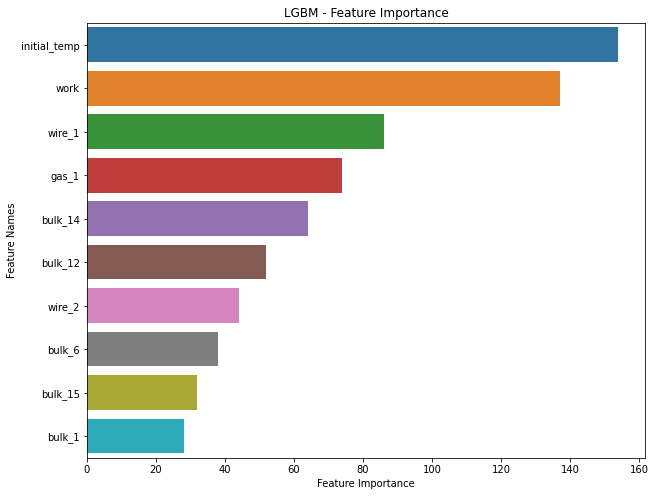

In [23]:
def plot_feature_importance(importance, names, model_type, limit=10):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'][:limit], y=fi_df['feature_names'][:limit])

    plt.title(f'{model_type} - Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    
# Получаем важности признаков для LGBMRegressor
importance = best_model.named_steps['model'].feature_importances_
feature_names = features_train.columns

# Визуализируем важности признаков
plot_feature_importance(importance, feature_names, model_type='LGBM')
plt.show()

График важности признаков показывает нам следующее:  
  
- Самым важным признаком является начальная температура, что вполне логично.
- Работа также очень значительно влияет на целевую
- Далее по убыванию влияния располагаются признаки wire_1, gas_1, bulk_14, bulk_12, wire_, bulk_6, bulk_15, bulk_1 и так далее

## Отчёт по проекту: Исследование влияния параметров на эффективность обработки стали

### Цели работы
В рамках данного проекта проведено исследование влияния различных параметров на эффективность обработки стали в металлургическом производстве. Проект включает в себя этапы предобработки данных, обучения моделей машинного обучения, подбора гиперпараметров, анализа важности признаков и оценки результатов.

### Этапы проекта

####  Предобработка данных
- Изучены и обработаны пропущенные значения в данных.
- Произведена конвертация временных меток в соответствующий формат.
- Выполнено удаление избыточных и малоинформативных признаков.
- Произведена аггрегация данных из всех таблиц в одну, так чтобы одному ковшу соответствовала одна строка.

####  Обучение моделей
- Использованы три модели машинного обучения: RandomForestRegressor, LGBMRegressor и CatBoostRegressor.
- Построены пайплайны для предобработки данных и обучения моделей.
- Произведен подбор гиперпараметров для каждой модели с использованием GridSearchCV.
- Оценена эффективность моделей на кросс-валидации.

####  Выбор лучшей модели
- Выбрана лучшая модель на основе наименьшего среднего абсолютного отклонения (MAE) на кросс-валидации.

####  Анализ важности признаков
- Проведен анализ важности признаков для лучшей модели (LGBMRegressor).
- Визуализированы результаты для лучшего понимания вклада каждого признака.


### Результаты

#### Лучшая модель
LGBMRegressor с оптимальными гиперпараметрами:
- max_depth: 5
- n_estimators: 50
- random_state: 131223

#### Важность признаков
1. Начальная температура
2. Работа
3. wire_1
4. gas_1
5. bulk_14
6. bulk_12
7. wire_
8. bulk_6
9. bulk_15
10. bulk_1

#### Оценка результатов
MAE на тестовой выборке для LGBMRegressor: 6.7871.
Данный результат можно считать положительным - отметка MAE=6.8 пройдена.

### Выводы и рекомендации
Проект успешно выявил ключевые факторы, влияющие на эффективность обработки стали. Важнейшими переменными оказались начальная температура и работа. Модель LGBMRegressor продемонстрировала наилучшую эффективность с MAE на уровне 6.5677 на кросс-валидации и 6.7871 на тестовой выборке. Рекомендуется использовать данную модель для прогнозирования результатов обработки стали, обеспечивая тем самым оптимизацию производственных процессов.